In [ ]:
#Installing transformers Module
# !pip install git+https://github.com/huggingface/transformers.git
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.1 MB/s 
     |████████████████████████████████| 895 kB 57.8 MB/s 
     |████████████████████████████████| 3.3 MB 52.5 MB/s 
     |████████████████████████████████| 636 kB 55.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Checking if GPU is running or not
!nvidia-smi

Sat Jul 24 18:16:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version

Python 3.7.11


In [ ]:
#Importing Required Modules
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import json
import gc

#### Data Preprocessing

In [ ]:
#Uploading data file from local PC to Colab
from google.colab import files
uploaded = files.upload()

Saving TrainData.csv to TrainData (1).csv


In [ ]:
#col_names=['text','B','category']
#df = pd.read_csv('train.csv',names=col_names,header=None)
col_names=['content','intent']
df = pd.read_csv('processed_data.csv',usecols=col_names)
df.head()

,content,intent
0,in this video as sudhansu sir explains that we...,activation_function
1,i have some doubts regarding activation functi...,activation_function
2,suppose i am using any activation function and...,activation_function
3,i know in case vanishing gradient weight of in...,activation_function
4,i am a student of dlcvnlp 25th batch and have ...,activation_function


In [ ]:
#df=df.drop('B',axis=1)
df=df.rename(columns={'content':'text','intent':'category'})

In [ ]:
df.head()

,text,category
0,in this video as sudhansu sir explains that we...,activation_function
1,i have some doubts regarding activation functi...,activation_function
2,suppose i am using any activation function and...,activation_function
3,i know in case vanishing gradient weight of in...,activation_function
4,i am a student of dlcvnlp 25th batch and have ...,activation_function


In [ ]:
df_cat_count=df['category'].value_counts().to_frame().reset_index().sort_values(by=['category'])
df_cat_count.columns=['category','counts']
min_category=df_cat_count[df_cat_count.counts < 15]['category'].tolist()
df.loc[df.category.isin(min_category),'category']='Others'

##### Encoding Categorical Variables

In [ ]:
df['encoded_cat'] = df['category'].astype('category').cat.codes
df.head()

,text,category,encoded_cat
0,in this video as sudhansu sir explains that we...,activation_function,1
1,i have some doubts regarding activation functi...,activation_function,1
2,suppose i am using any activation function and...,activation_function,1
3,i know in case vanishing gradient weight of in...,activation_function,1
4,i am a student of dlcvnlp 25th batch and have ...,activation_function,1


In [ ]:
df['category'].value_counts()

welcome_reply              6298
internship_query           1785
batch_details              1146
user_name                   682
tensorflow_installation     632
                           ... 
assignment_powerbi           19
assignment_knn               18
cufflinks_installation       18
blog                         16
bot_timing                   15
Name: category, Length: 173, dtype: int64

In [ ]:
df.tail()

,text,category,encoded_cat
24190,i wanted to know how do you call while attendi...,zoom_platform_query,172
24191,dl course today...zoom attendees reached 1000....,zoom_platform_query,172
24192,zoom app was not working well aind even attend...,zoom_platform_query,172
24193,is their any change in settings that need to b...,zoom_platform_query,172
24194,good morning sir.. i&apos;m a student of mld6t...,zoom_platform_query,172


##### Getting a distribution of words using box plot

In [ ]:
df['word_count']=df['text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


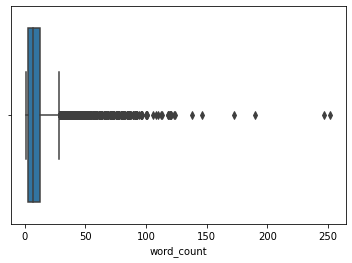

In [ ]:
import seaborn as sns
sns.boxplot(df['word_count'])

In [ ]:
df=df.drop('word_count',axis=1)

In [ ]:
data_texts = df["text"].to_list() 
data_labels = df["encoded_cat"].to_list()

In [ ]:
print(df["encoded_cat"].min(),df["encoded_cat"].max())

0 172


##### Split Data into train,validation and test dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0,stratify=data_labels)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, stratify=train_labels)

#### DistillBert Tokenizer

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

#### Loading data from Memory to Tensor Dataset and applying Transformation on it

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

#### DistillBert Training

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=173)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
for layer_n in model.layers:
  print(layer_n)

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  133037    
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 67,086,509
Trainable params: 67,086,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=10, batch_size=16, validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=5, batch_size=16, validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/5
1198/1198 [==============================] - 661s 552ms/step - loss: 0.0843 - accuracy: 0.9706 - val_loss: 0.8511 - val_accuracy: 0.8320
Epoch 2/5
1198/1198 [==============================] - 661s 552ms/step - loss: 0.0691 - accuracy: 0.9748 - val_loss: 0.9079 - val_accuracy: 0.8283
Epoch 3/5
1198/1198 [==============================] - 662s 552ms/step - loss: 0.0767 - accuracy: 0.9735 - val_loss: 0.9520 - val_accuracy: 0.8225
Epoch 4/5
1198/1198 [==============================] - 662s 553ms/step - loss: 0.0715 - accuracy: 0.9745 - val_loss: 0.9809 - val_accuracy: 0.8250
Epoch 5/5
1198/1198 [==============================] - 662s 553ms/step - loss: 0.0605 - accuracy: 0.9786 - val_loss: 0.9491 - val_accuracy: 0.8326


In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=10, batch_size=16, validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/10
1198/1198 [==============================] - 662s 552ms/step - loss: 0.0633 - accuracy: 0.9766 - val_loss: 0.9756 - val_accuracy: 0.8281
Epoch 2/10
1198/1198 [==============================] - 661s 552ms/step - loss: 0.0611 - accuracy: 0.9772 - val_loss: 1.0566 - val_accuracy: 0.8206
Epoch 3/10
1198/1198 [==============================] - 661s 552ms/step - loss: 0.0656 - accuracy: 0.9765 - val_loss: 0.9792 - val_accuracy: 0.8270
Epoch 4/10
1198/1198 [==============================] - 664s 554ms/step - loss: 0.0610 - accuracy: 0.9782 - val_loss: 1.0190 - val_accuracy: 0.8188
Epoch 5/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0621 - accuracy: 0.9776 - val_loss: 0.9488 - val_accuracy: 0.8229
Epoch 6/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0549 - accuracy: 0.9800 - val_loss: 1.0084 - val_accuracy: 0.8254
Epoch 7/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0566 - accuracy: 0.9791 - val_

In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=10, batch_size=16, validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0578 - accuracy: 0.9793 - val_loss: 1.0543 - val_accuracy: 0.8279
Epoch 2/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0486 - accuracy: 0.9807 - val_loss: 1.0659 - val_accuracy: 0.8268
Epoch 3/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0460 - accuracy: 0.9826 - val_loss: 1.1134 - val_accuracy: 0.8243
Epoch 4/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0504 - accuracy: 0.9819 - val_loss: 1.1137 - val_accuracy: 0.8293
Epoch 5/10
1198/1198 [==============================] - 666s 556ms/step - loss: 0.0506 - accuracy: 0.9816 - val_loss: 1.1503 - val_accuracy: 0.8289
Epoch 6/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0463 - accuracy: 0.9820 - val_loss: 1.1032 - val_accuracy: 0.8287
Epoch 7/10
1198/1198 [==============================] - 665s 555ms/step - loss: 0.0337 - accuracy: 0.9856 - val_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MLProjects/CRM_Chatbot

/content/drive/MyDrive/MLProjects/CRM_Chatbot


In [ ]:
model.save_weights('my_checkpoint_35epochs')

The model seems to be overfitting as after a particular point of time train accuracry increases whereas validation accuracy start to become stangnent and dip.

In [ ]:
save_directory = "/content/drive/MyDrive/MLProjects/CRM_Chatbot" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/MLProjects/CRM_Chatbot/tokenizer_config.json',
 '/content/drive/MyDrive/MLProjects/CRM_Chatbot/special_tokens_map.json',
 '/content/drive/MyDrive/MLProjects/CRM_Chatbot/vocab.txt',
 '/content/drive/MyDrive/MLProjects/CRM_Chatbot/added_tokens.json')

In [ ]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/MLProjects/CRM_Chatbot were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/MLProjects/CRM_Chatbot and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test_text='installation issue with anaconda'
test_text

'installation issue with anaconda'

In [ ]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]
df.loc[df['encoded_cat'] == prediction_value, 'category'].iloc[0]

'anaconda_installation'